# Imorting required Libraries

In [205]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Loading dataset (Oxford pets because of its high res) and using a single image and viewing it

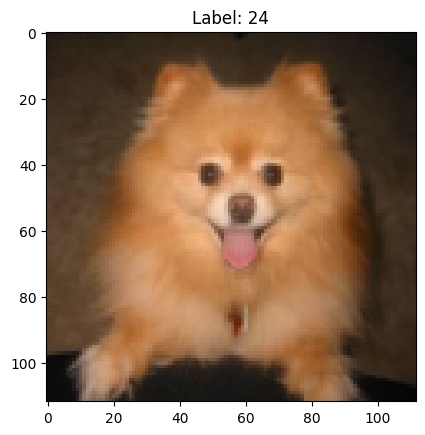

In [206]:

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize the image to 112x112
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])

# Load Oxford Pets dataset (train split)
trainset = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

# Get a single sample image and label
data_iter = iter(trainloader)
image, label = next(data_iter)

# Plot the original image
image_np = np.transpose(image[0].numpy(), (1, 2, 0))  # Convert the tensor to numpy format
plt.imshow(image_np)
plt.title(f'Label: {label.item()}')
plt.show()



# Visualize Feature Maps

In [207]:
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image, title):
    model.eval()
    with torch.no_grad():
        feature_maps = model(image)[0] if isinstance(model(image), tuple) else model(image)
#     print(feature_maps)
    print(feature_maps.shape)
    
    # Get the number of feature maps
    num_feature_maps = feature_maps.shape[1]
    
    # Create subplots
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)

    # Ensure axes is iterable regardless of the number of feature maps
    if num_feature_maps == 1:
        axes = [axes]  # Convert single Axes object to a list for consistency

    for i in range(num_feature_maps):
        axes[i].imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis')
        axes[i].axis('off')

    plt.show()

# Example usage (ensure you have a suitable model and input image)
# visualize_feature_maps(model, input_tensor, "Combined RGB Feature Map")

# import matplotlib.pyplot as plt

# def visualize_feature_maps(model, image, title):
#     model.eval()
#     with torch.no_grad():
#         feature_maps = model(image)[0] if isinstance(model(image), tuple) else model(image)

#     print(feature_maps.shape)
    
#     # Get the number of feature maps and reshape to 2D
#     num_feature_maps = feature_maps.shape[1]
    
#     # Calculate height and width (assumed to be a square)
#     height = width = int(np.sqrt(feature_maps.shape[2]))  # Assuming 12544 is a square

#     # Create subplots
#     fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 10))
#     fig.suptitle(title, fontsize=16)

#     # Ensure axes is iterable regardless of the number of feature maps
#     if num_feature_maps == 1:
#         axes = [axes]  # Convert single Axes object to a list for consistency
    
#     for i in range(num_feature_maps):
#         # Reshape the feature map to 2D
#         feature_map = feature_maps[0, i].cpu().numpy().reshape((height, width))
#         print(feature_map.shape)
#         axes[i].imshow(feature_map, cmap='viridis')
#         axes[i].axis('off')

#     plt.show()



# Depthwise Convolution Class

This cell defines a custom depthwise convolutional layer. The `DepthwiseConv` class is structured as follows:

1. **Initialization**:
   - Inherits from `nn.Module`.
   - Takes the following parameters:
     - `in_channels`: Number of input channels.
     - `kernel_size`: Size of the convolution kernel.
   - Initializes a depthwise convolution layer using `nn.Conv2d`, setting:
     - The number of input and output channels to `in_channels`.
     - The specified kernel size with padding set to 1.
     - Groups equal to the number of input channels to ensure that each input channel is convolved separately.

2. **Forward Pass**:
   - Implements the `forward` method, which applies the depthwise convolution to the input tensor `x` and returns the convolved output.


In [210]:
class DepthwiseConv(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super(DepthwiseConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=1, groups=in_channels)

    def forward(self, x):
        return self.depthwise(x)


torch.Size([1, 3, 112, 112])


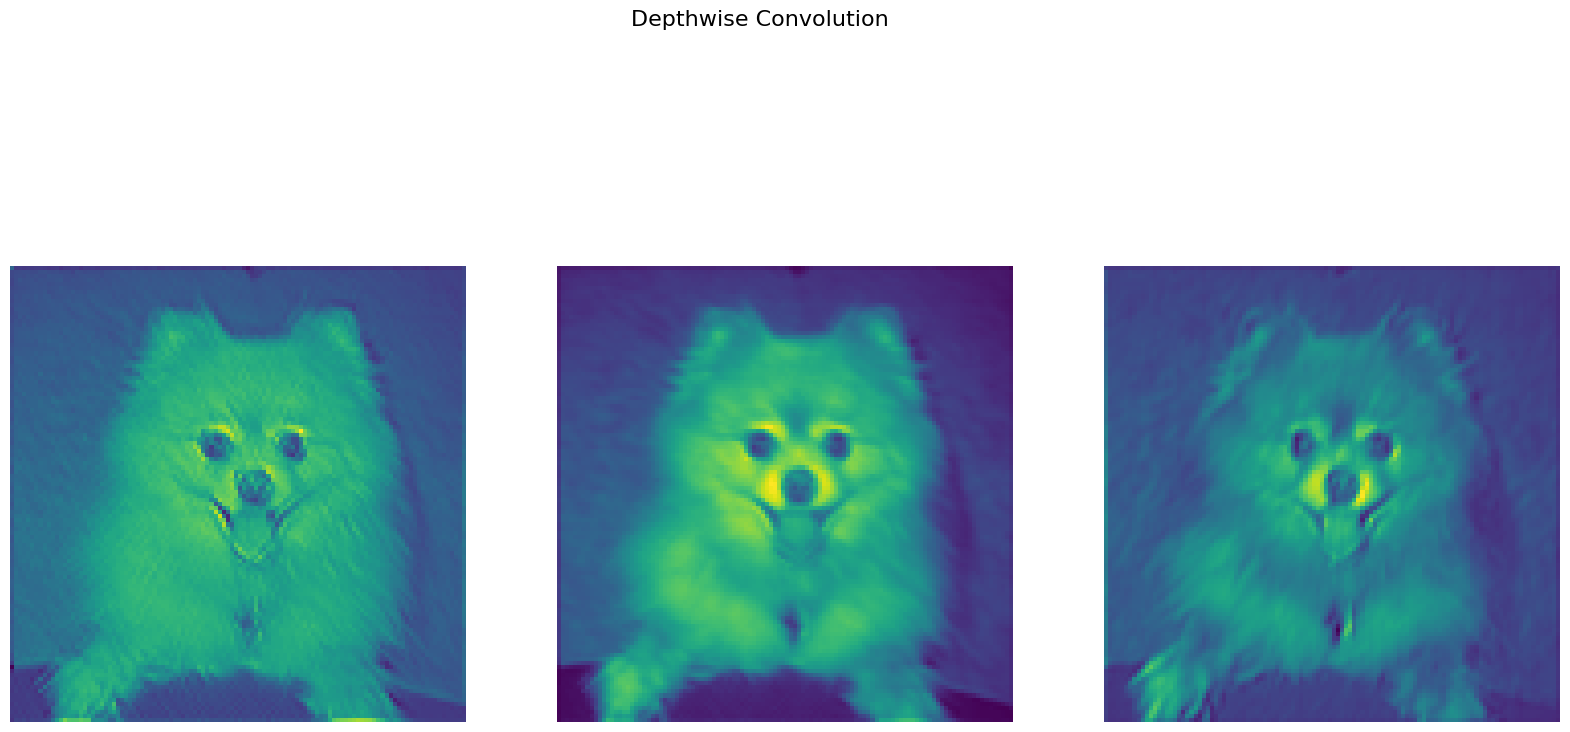

In [211]:
# Sample image from CIFAR-10
image = image.cuda()

# Move models to CUDA if available
depthwise_model = DepthwiseConv(3, 3).cuda()

visualize_feature_maps(depthwise_model, image, "Depthwise Convolution")

# Self-Attention Class

This cell defines a custom self-attention layer. The `SelfAttention` class is structured as follows:

1. **Initialization**:
   - Inherits from `nn.Module`.
   - Takes the following parameter:
     - `in_channels`: Number of input channels.
   - Initializes three convolutional layers:
     - `query`: A convolutional layer for generating the query vectors.
     - `key`: A convolutional layer for generating the key vectors.
     - `value`: A convolutional layer for generating the value vectors.
   - Each convolutional layer uses a kernel size of 1.

2. **Forward Pass**:
   - Implements the `forward` method, which processes the input tensor `x` as follows:
     - Extracts the batch size, channel count, height, and width from the input tensor.
     - Computes the query (`q`), key (`k`), and value (`v`) matrices by applying the respective convolutional layers and reshaping them.
     - Computes the attention weights using the dot product of the query and key matrices.
     - Applies the softmax function to the attention weights for normalization.
     - Computes the output by applying the attention weights to the value matrix and reshaping the result back to the original dimensions.
   - Returns the output tensor and the attention weights.


In [226]:
import torch
import torch.nn as nn

class SimpleSelfAttention(nn.Module):
    def __init__(self):
        super(SimpleSelfAttention, self).__init__()

    def forward(self, X):
        """
        Forward pass for the self-attention mechanism.
        
        X: Input feature matrix (each row is a pixel's feature vector)
           Shape: (batch_size, channels, height, width), where batch_size is the number of images,
           channels is the number of feature maps, height and width are the spatial dimensions.
        
        Returns: Weighted sum of input features using self-attention.
        """
        batch_size, channels, height, width = X.shape  # Ensure shape is [1, 3, 112, 112]
        assert height == 112 and width == 112, "Input height and width must both be 112"
        
        X_flat = X.view(batch_size, channels, -1)  # Shape: (batch_size, channels, N), where N = height * width
        X_flat = X_flat.permute(0, 2, 1)  # Shape: (batch_size, N, channels), for compatibility
#         print("x_flat: ", X_flat)
        
        result = X_flat.transpose(1, 2)@ X_flat 
#         print("result: ", result)
        # Compute the similarity scores (dot-product attention)
        scores = torch.exp(X_flat @ X_flat.transpose(1, 2))
#         print("sores: ", scores)
        # Normalize the attention scores by rows
        attention_weights = scores / scores.sum(dim=-1, keepdim=True)  # Normalize over the N dimension
#         print("attention weights: ", attention_weights)
        # Compute the attention-weighted output
        output_flat = attention_weights @ X_flat  # Shape: (batch_size, N, channels)
#         print("output flat: ", output_flat)
        # Reshape the output back to the original image shape (batch_size, channels, height, width)
        output = output_flat.view(batch_size, channels, height, width)
#         print("output: ", output)
        return output, attention_weights

# class SimpleSelfAttention(nn.Module):
#     def __init__(self, in_channels):
#         super(SimpleSelfAttention, self).__init__()
#         self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
#         self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
#         self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

#     def forward(self, x):
#         batch_size, c, h, w = x.size()
#         q = self.query(x).view(batch_size, c, -1)
#         k = self.key(x).view(batch_size, c, -1)
#         v = self.value(x).view(batch_size, c, -1)

#         attn_weights = torch.bmm(q.transpose(1, 2), k)  # Compute attention weights
#         attn_weights = F.softmax(attn_weights, dim=-1)

#         out = torch.bmm(v, attn_weights).view(batch_size, c, h, w)
#         return out, attn_weights


torch.Size([1, 3, 112, 112])


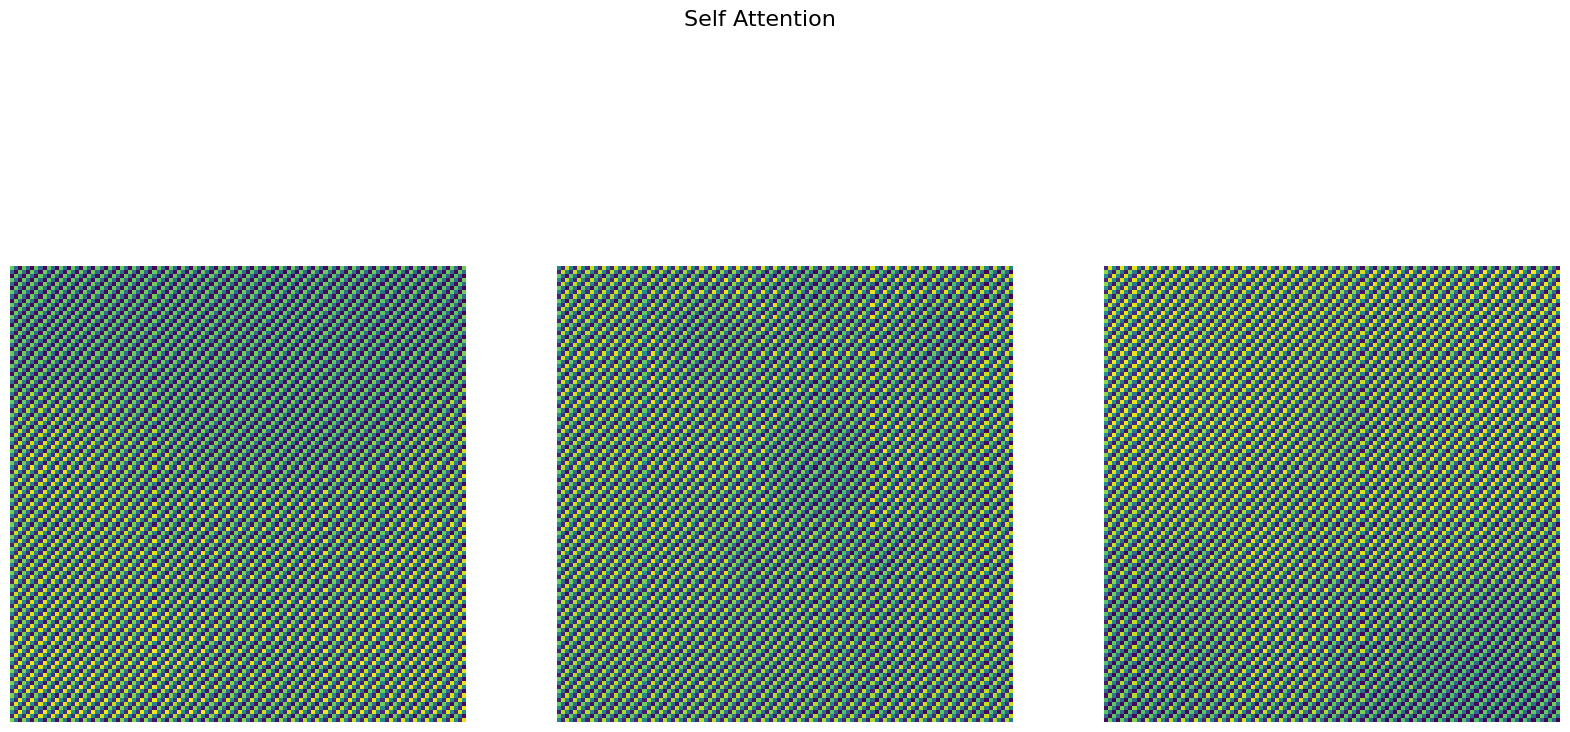

In [214]:
self_attention_model = SimpleSelfAttention().cuda()
visualize_feature_maps(self_attention_model, image, "Self Attention")

# Post-Normalization Class

This cell defines a custom post-normalization layer that combines depthwise convolution and self-attention. The `PostNormalization` class is structured as follows:

1. **Initialization**:
   - Inherits from `nn.Module`.
   - Takes the following parameters:
     - `in_channels`: Number of input channels.
     - `kernel_size`: Size of the convolution kernel.
   - Initializes:
     - A depthwise convolutional layer (`depthwise`) using `nn.Conv2d`, configured with padding and grouped by the number of input channels.
     - An instance of the `SelfAttention` class to handle self-attention operations.

2. **Forward Pass**:
   - Implements the `forward` method, which processes the input tensor `x` as follows:
     - Applies the depthwise convolution to `x` to get `conv_out`.
     - Computes the self-attention output (`attn_out`) and attention weights (`attn_weights`) by passing `x` to the self-attention layer.
     - Combines the outputs of the depthwise convolution and self-attention layers, then applies layer normalization to the sum.
   - Returns the normalized output and the attention weights.


In [238]:
class PostNormalization(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super(PostNormalization, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=1, groups=in_channels)
        self.self_attention = SimpleSelfAttention()

    def forward(self, x):
        conv_out = self.depthwise(x)
        attn_out, attn_weights = self.self_attention(x)
        return F.layer_norm(conv_out + attn_out, x.size()), attn_weights


torch.Size([1, 3, 112, 112])


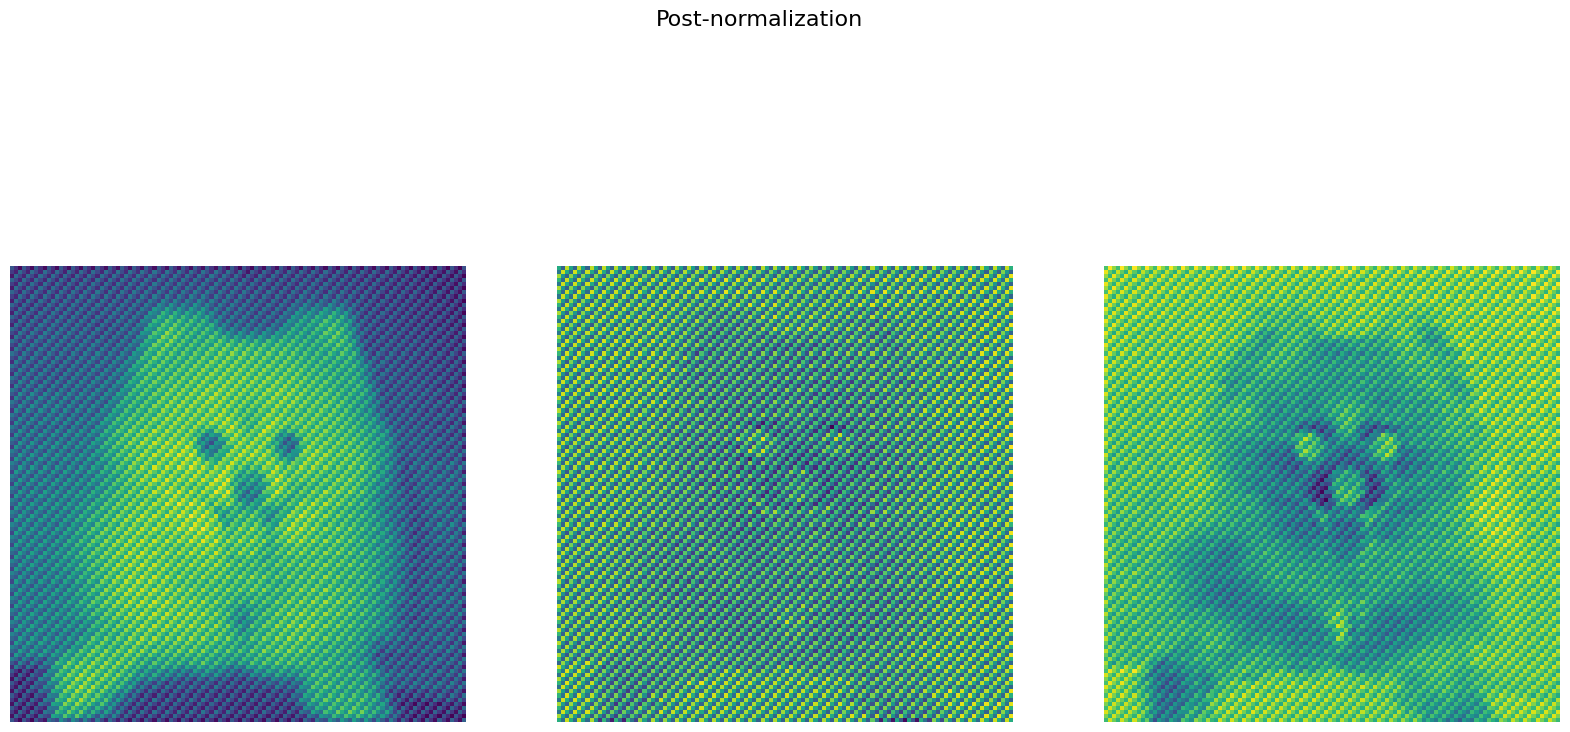

In [216]:
post_norm_model = PostNormalization(3, 3).cuda()
visualize_feature_maps(post_norm_model, image, "Post-normalization")

# Pre-Normalization Class

This cell defines a custom pre-normalization layer that incorporates depthwise convolution and self-attention. The `PreNormalization` class is structured as follows:

1. **Initialization**:
   - Inherits from `nn.Module`.
   - Takes the following parameters:
     - `in_channels`: Number of input channels.
     - `kernel_size`: Size of the convolution kernel.
   - Initializes:
     - A depthwise convolutional layer (`depthwise`) using `nn.Conv2d`, configured with padding and grouped by the number of input channels.
     - An instance of the `SelfAttention` class to perform self-attention operations.

2. **Forward Pass**:
   - Implements the `forward` method, which processes the input tensor `x` as follows:
     - Applies layer normalization to the input tensor to produce `normalized_input`.
     - Applies the depthwise convolution to the normalized input to obtain `conv_out`.
     - Computes the self-attention output (`attn_out`) and attention weights (`attn_weights`) using the normalized input.
     - Returns the sum of the convolution and attention outputs, along with the attention weights.


In [239]:
class PreNormalization(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super(PreNormalization, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=1, groups=in_channels)
        self.self_attention = SimpleSelfAttention()

    def forward(self, x):
        normalized_input = F.layer_norm(x, x.size())
        conv_out = self.depthwise(normalized_input)
        attn_out, attn_weights = self.self_attention(normalized_input)
        return conv_out + attn_out, attn_weights


torch.Size([1, 3, 112, 112])


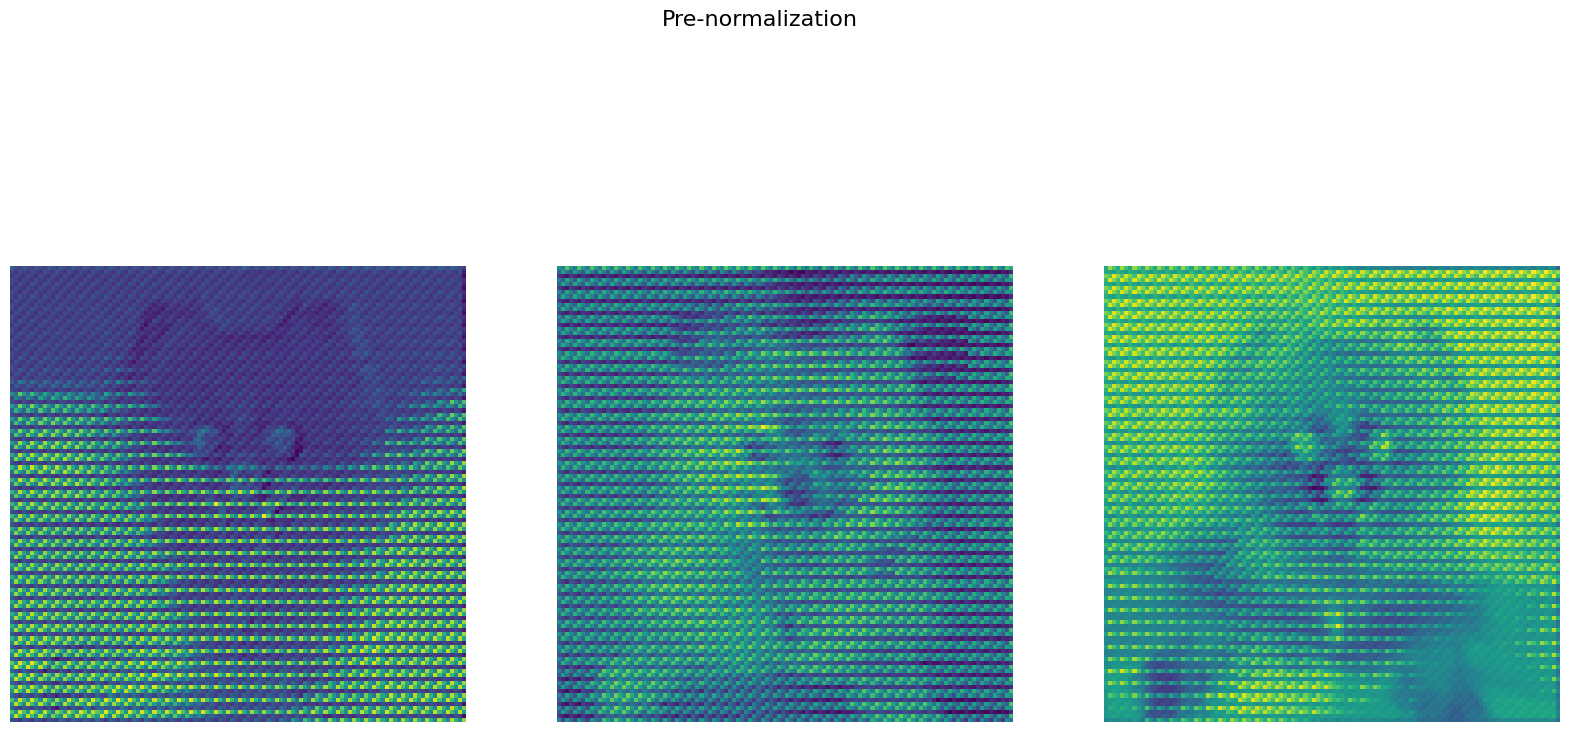

In [218]:
pre_norm_model = PreNormalization(3, 3).cuda()
visualize_feature_maps(pre_norm_model, image, "Pre-normalization")

# Attention Modulated Convolution Class

This cell defines a custom attention-modulated convolution layer that combines depthwise convolution with self-attention. The `AttentionModulatedConv` class is structured as follows:

1. **Initialization**:
   - Inherits from `nn.Module`.
   - Takes the following parameters:
     - `in_channels`: Number of input channels.
     - `kernel_size`: Size of the convolution kernel.
   - Initializes:
     - A depthwise convolutional layer (`depthwise`) using `nn.Conv2d`, configured with padding and grouped by the number of input channels.
     - An instance of the `SelfAttention` class to perform self-attention operations.

2. **Forward Pass**:
   - Implements the `forward` method, which processes the input tensor `x` as follows:
     - Computes the self-attention output (`attn_out`) and attention weights (`attn_weights`) by passing `x` to the self-attention layer.
     - Modulates the depthwise convolution output by multiplying it with the self-attention output.
     - Returns the modulated convolution output and the attention weights.


In [240]:
class AttentionModulatedConv(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super(AttentionModulatedConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=1, groups=in_channels)
        self.self_attention = SimpleSelfAttention()

    def forward(self, x):
        attn_out, attn_weights = self.self_attention(x)
        modulated_conv = attn_out * self.depthwise(x)
        return modulated_conv, attn_weights


torch.Size([1, 3, 112, 112])


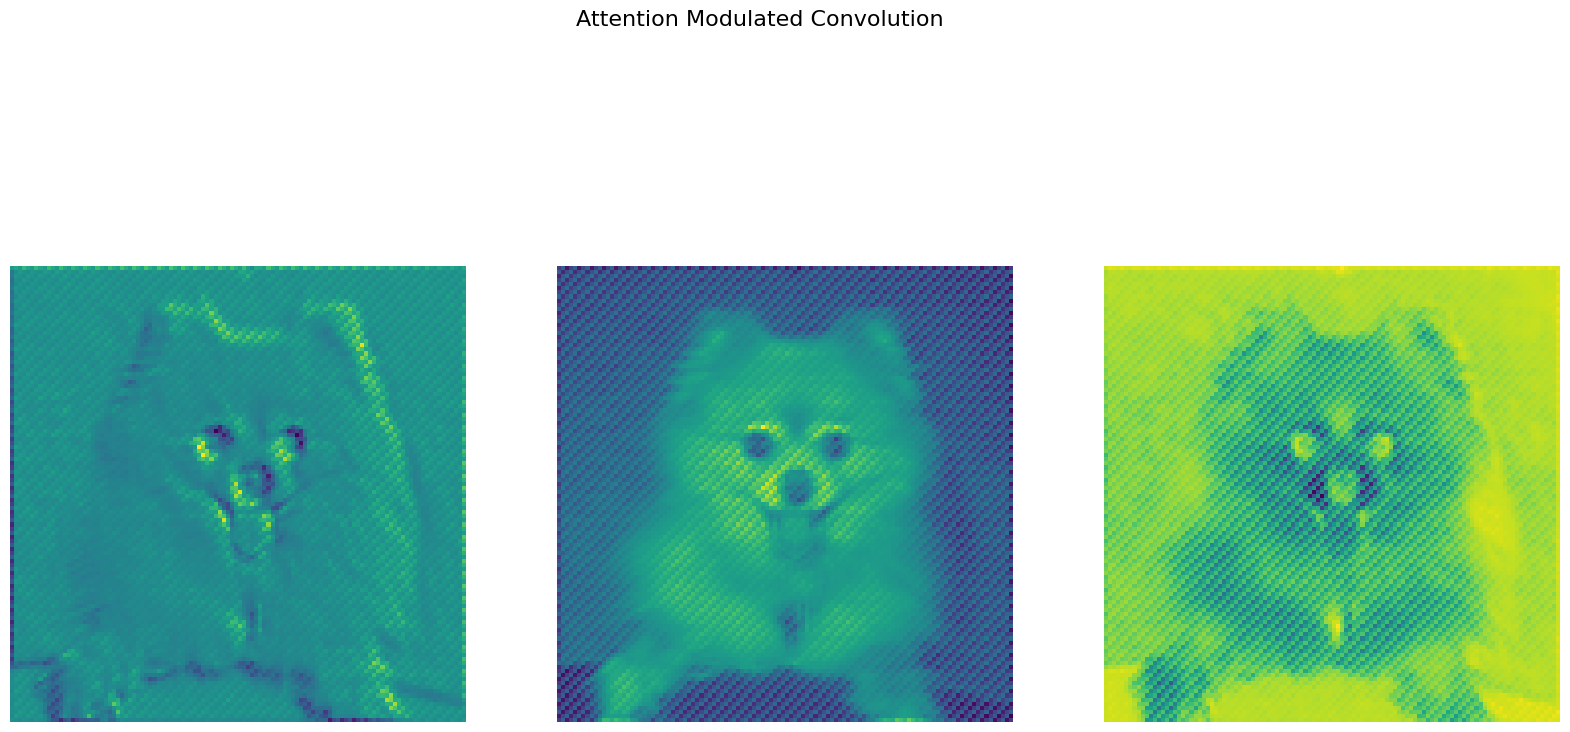

In [220]:
attn_modulated_conv_model = AttentionModulatedConv(3, 3).cuda()
visualize_feature_maps(attn_modulated_conv_model, image, "Attention Modulated Convolution")

# Convolution Modulated Attention Class

This cell defines a custom convolution modulated attention layer that combines depthwise convolution with self-attention. The `ConvModulatedAttention` class is structured as follows:

1. **Initialization**:
   - Inherits from `nn.Module`.
   - Takes the following parameters:
     - `in_channels`: Number of input channels.
     - `kernel_size`: Size of the convolution kernel.
   - Initializes:
     - A depthwise convolutional layer (`depthwise`) using `nn.Conv2d`, configured with padding and grouped by the number of input channels.
     - An instance of the `SelfAttention` class to perform self-attention operations.

2. **Forward Pass**:
   - Implements the `forward` method, which processes the input tensor `x` as follows:
     - Applies the depthwise convolution to `x` to obtain `conv_out`.
     - Computes the self-attention output (`attn_out`) and attention weights (`attn_weights`) using `conv_out`.
     - Returns the self-attention output and the attention weights.


In [236]:
# class SimpleSelfAttention(nn.Module):
#     def __init__(self, in_channels):
#         super(SimpleSelfAttention, self).__init__()
#         self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
#         self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
#         self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

#     def forward(self, x):
#         batch_size, c, h, w = x.size()
#         q = self.query(x).view(batch_size, c, -1)
#         k = self.key(x).view(batch_size, c, -1)
#         v = self.value(x).view(batch_size, c, -1)

#         attn_weights = torch.bmm(q.transpose(1, 2), k)  # Compute attention weights
#         attn_weights = F.softmax(attn_weights, dim=-1)

#         out = torch.bmm(v, attn_weights).view(batch_size, c, h, w)
#         return out, attn_weights
class SimpleSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SimpleSelfAttention, self).__init__()
        self.query = nn.Linear(in_channels, in_channels)
        self.key = nn.Linear(in_channels, in_channels)
        self.value = nn.Linear(in_channels, in_channels)

    def forward(self, x):
        batch_size, c, h, w = x.size()
        x_flat = x.view(batch_size, -1, c)  # Flatten height and width dimensions (batch_size, num_patches, in_channels)
        
        q = self.query(x_flat)  # (batch_size, num_patches, in_channels)
        k = self.key(x_flat)    # (batch_size, num_patches, in_channels)
        v = self.value(x_flat)  # (batch_size, num_patches, in_channels)

        attn_weights = torch.bmm(q, k.transpose(1, 2))  # Compute attention weights
        attn_weights = F.softmax(attn_weights, dim=-1)

        out = torch.bmm(attn_weights, v)  # (batch_size, num_patches, in_channels)
        out = out.view(batch_size, c, h, w)  # Reshape back to (batch_size, c, h, w)
        
        return out, attn_weights

In [222]:
class ConvModulatedAttention(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super(ConvModulatedAttention, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=1, groups=in_channels)
        self.self_attention = SimpleSelfAttention(in_channels)

    def forward(self, x):
        conv_out = self.depthwise(x)
        attn_out, attn_weights = self.self_attention(conv_out)
        return attn_out, attn_weights


torch.Size([1, 3, 112, 112])


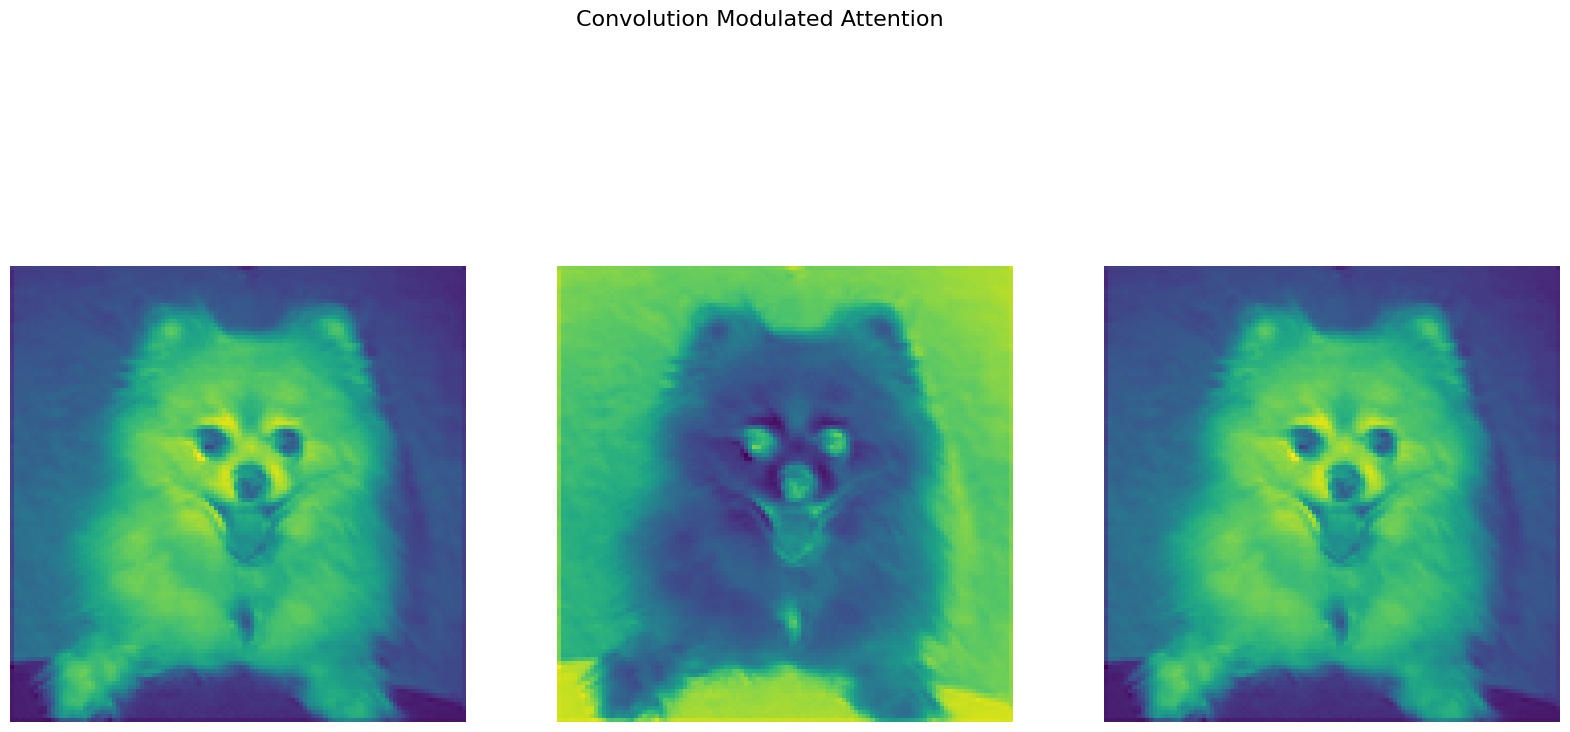

In [223]:


conv_modulated_attn_model = ConvModulatedAttention(3, 3).cuda()
visualize_feature_maps(conv_modulated_attn_model, image, "Convolution Modulated Attention")


# Visualize attention map as heat map using attention weights

In [227]:
def visualize_attention_maps(attention_weights, image_size, title="Attention Map"):
    # attention_weights has shape (batch_size, sequence_length, sequence_length)
    # We will take the first image in the batch and reshape the attention map

    attention_map = attention_weights[0]  # Take the first sample from the batch

    # The attention map is of size (sequence_length, sequence_length), sequence_length = h * w
    sequence_length = image_size[0] * image_size[1]

    if attention_map.shape[-1] != sequence_length:
        raise ValueError(f"Expected attention map of size {sequence_length}, got {attention_map.shape[-1]} instead.")

    # Reshape the attention weights back to the image shape (112x112)
    attention_map = attention_map.mean(dim=0).view(image_size[0], image_size[1]).cpu().detach().numpy()

    # Plotting the attention map
    plt.imshow(attention_map, cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.show()


# Visualize attention matrix as heat map and raw probabilities using attention weights to see global context

In [228]:
def visualize_attention_matrix(attention_weights, title="Attention Matrix"):
    # Select the first image's attention weights
    attn_matrix = attention_weights[0].cpu().detach().numpy()
    print(attn_matrix)
    # Plot the attention weights matrix (probabilities)
    plt.matshow(attn_matrix, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Initializing models for self attention 

In [241]:
self_attention_model = SimpleSelfAttention().cuda()
post_norm_model = PostNormalization(3, 3).cuda()
pre_norm_model = PreNormalization(3, 3).cuda()
attn_modulated_conv_model = AttentionModulatedConv(3, 3).cuda()
conv_modulated_attn_model = ConvModulatedAttention(3, 3).cuda()

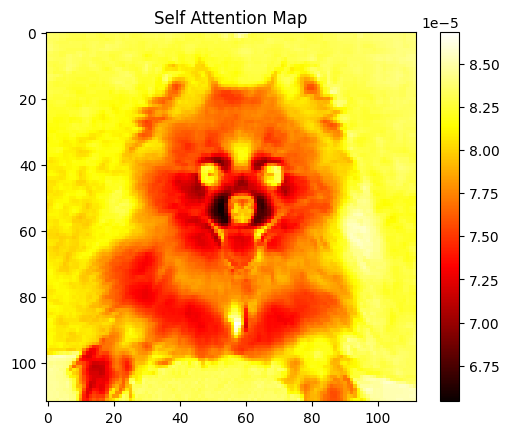

[[8.6611115e-05 8.6473352e-05 8.6402870e-05 ... 8.8917252e-05
  8.8917252e-05 8.8917252e-05]
 [8.6560351e-05 8.6422981e-05 8.6353321e-05 ... 8.8849294e-05
  8.8849294e-05 8.8849294e-05]
 [8.6534288e-05 8.6396976e-05 8.6327855e-05 ... 8.8814952e-05
  8.8814952e-05 8.8814952e-05]
 ...
 [8.7485460e-05 8.7342669e-05 8.7257024e-05 ... 9.0085421e-05
  9.0085421e-05 9.0085421e-05]
 [8.7485460e-05 8.7342669e-05 8.7257024e-05 ... 9.0085421e-05
  9.0085421e-05 9.0085421e-05]
 [8.7485460e-05 8.7342669e-05 8.7257024e-05 ... 9.0085421e-05
  9.0085421e-05 9.0085421e-05]]


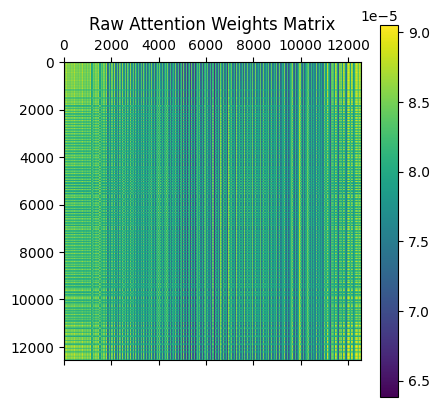

In [242]:
_, self_attention_weights = self_attention_model(image)
visualize_attention_maps(self_attention_weights, image_size=(112, 112), title="Self Attention Map")
visualize_attention_matrix(self_attention_weights, title="Raw Attention Weights Matrix")

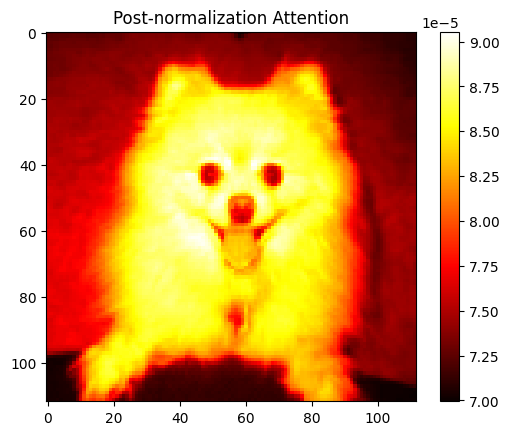

[[7.6973818e-05 7.6984135e-05 7.7040568e-05 ... 7.6259552e-05
  7.6259552e-05 7.6259552e-05]
 [7.6922523e-05 7.6933378e-05 7.6990531e-05 ... 7.6194323e-05
  7.6194323e-05 7.6194323e-05]
 [7.6826582e-05 7.6838718e-05 7.6897020e-05 ... 7.6071599e-05
  7.6071599e-05 7.6071599e-05]
 ...
 [7.8383571e-05 7.8376841e-05 7.8414319e-05 ... 7.8064062e-05
  7.8064062e-05 7.8064062e-05]
 [7.8383571e-05 7.8376841e-05 7.8414319e-05 ... 7.8064062e-05
  7.8064062e-05 7.8064062e-05]
 [7.8383571e-05 7.8376841e-05 7.8414319e-05 ... 7.8064062e-05
  7.8064062e-05 7.8064062e-05]]


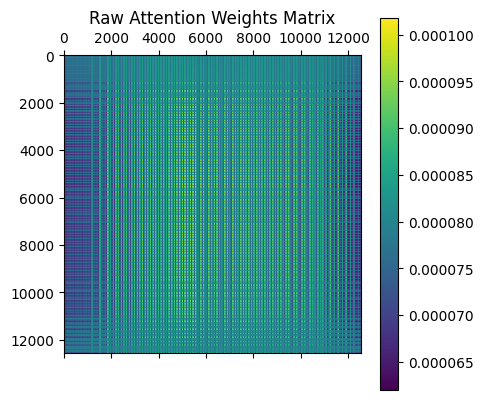

In [243]:
_, post_norm_attention_weights = post_norm_model(image)
visualize_attention_maps(post_norm_attention_weights, image_size=(112, 112), title = "Post-normalization Attention")
visualize_attention_matrix(post_norm_attention_weights, title="Raw Attention Weights Matrix")

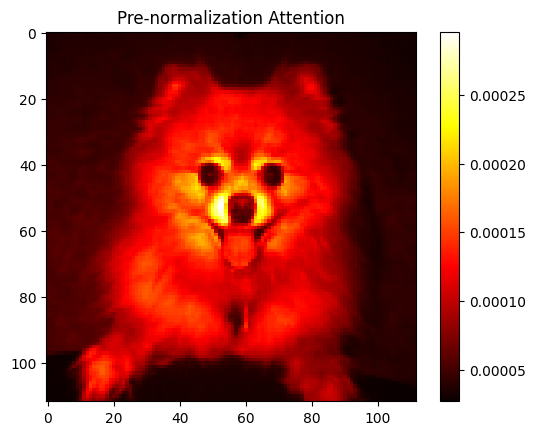

[[3.7558704e-05 3.8111350e-05 3.8277543e-05 ... 3.0892752e-05
  3.0892752e-05 3.0892752e-05]
 [3.7772839e-05 3.8324251e-05 3.8491082e-05 ... 3.1107917e-05
  3.1107917e-05 3.1107917e-05]
 [3.7918304e-05 3.8467224e-05 3.8634083e-05 ... 3.1251318e-05
  3.1251318e-05 3.1251318e-05]
 ...
 [3.9187053e-05 3.9800652e-05 3.9942261e-05 ... 3.2571585e-05
  3.2571585e-05 3.2571585e-05]
 [3.9187053e-05 3.9800652e-05 3.9942261e-05 ... 3.2571585e-05
  3.2571585e-05 3.2571585e-05]
 [3.9187053e-05 3.9800652e-05 3.9942261e-05 ... 3.2571585e-05
  3.2571585e-05 3.2571585e-05]]


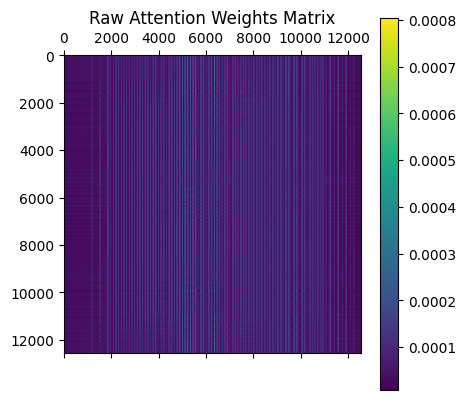

In [244]:
_, pre_norm_attention_weights = pre_norm_model(image)
visualize_attention_maps(pre_norm_attention_weights, image_size=(112, 112), title = "Pre-normalization Attention")
visualize_attention_matrix(pre_norm_attention_weights, title="Raw Attention Weights Matrix")

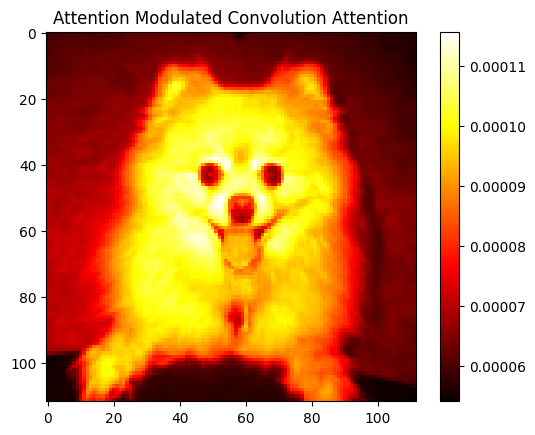

[[6.6540386e-05 6.6667242e-05 6.6839377e-05 ... 6.3293410e-05
  6.3293410e-05 6.3293410e-05]
 [6.6423068e-05 6.6550812e-05 6.6724111e-05 ... 6.3151885e-05
  6.3151885e-05 6.3151885e-05]
 [6.6313187e-05 6.6441760e-05 6.6616187e-05 ... 6.3019586e-05
  6.3019586e-05 6.3019586e-05]
 ...
 [6.8917929e-05 6.9025809e-05 6.9173344e-05 ... 6.6180321e-05
  6.6180321e-05 6.6180321e-05]
 [6.8917929e-05 6.9025809e-05 6.9173344e-05 ... 6.6180321e-05
  6.6180321e-05 6.6180321e-05]
 [6.8917929e-05 6.9025809e-05 6.9173344e-05 ... 6.6180321e-05
  6.6180321e-05 6.6180321e-05]]


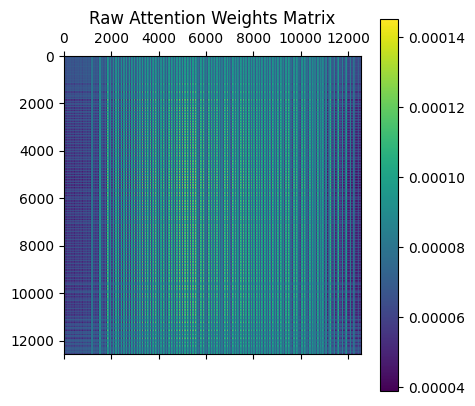

In [245]:
_, attn_modulated_conv_weights = attn_modulated_conv_model(image)
visualize_attention_maps(attn_modulated_conv_weights, image_size=(112, 112), title = "Attention Modulated Convolution Attention")
visualize_attention_matrix(attn_modulated_conv_weights, title="Raw Attention Weights Matrix")

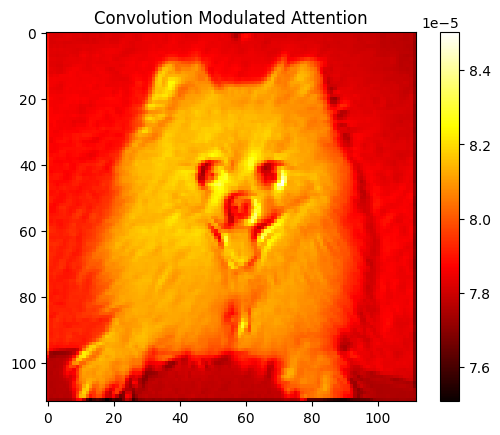

[[7.7709563e-05 7.7434510e-05 7.7422403e-05 ... 7.6596392e-05
  7.6576049e-05 7.6498261e-05]
 [7.7658311e-05 7.7377197e-05 7.7365192e-05 ... 7.6544500e-05
  7.6523662e-05 7.6446711e-05]
 [7.7661738e-05 7.7381061e-05 7.7369055e-05 ... 7.6548880e-05
  7.6528064e-05 7.6451164e-05]
 ...
 [7.7556062e-05 7.7262266e-05 7.7250173e-05 ... 7.6423319e-05
  7.6401455e-05 7.6324388e-05]
 [7.7553312e-05 7.7259203e-05 7.7247118e-05 ... 7.6420860e-05
  7.6398974e-05 7.6321987e-05]
 [7.7546378e-05 7.7251403e-05 7.7239310e-05 ... 7.6412383e-05
  7.6390439e-05 7.6313416e-05]]


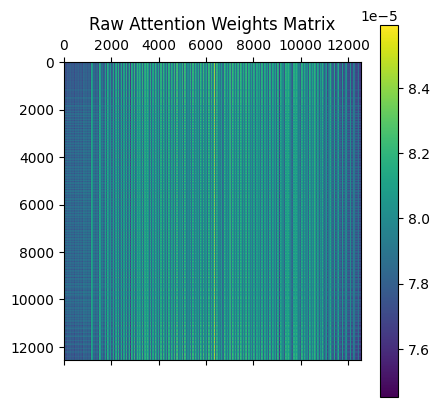

In [246]:
_, conv_modulated_attn_weights = conv_modulated_attn_model(image)
visualize_attention_maps(conv_modulated_attn_weights, image_size=(112, 112), title = "Convolution Modulated Attention")
visualize_attention_matrix(conv_modulated_attn_weights, title="Raw Attention Weights Matrix")